# Predicting COVID Cases Across US Counties

### The goal of this project is to predict the future number of COVID-19 cases of each county in the United States. To do this, previous data about the number of daily COVID-19 cases will be used as the baseline for future predictions. The machine learning algorithm will also take into account many various features which may influence the number of cases in the county. Some of the features used include education level, median household income, and unemployment rates.

Below are the packages used for this project. Here is a brief explanation of what each package is used for. *This is not a completely inclusive list, as many of these packages serve multiple purposes for this project.*

* **pandas**: Used to format and manipulate dataframes of the datasets, features, and other compilations of information needed for this project.

* **matplotlib**: Used to visualize the data to show trends such as error margins and observations versus predictions.

* **numpy**: Used to create, store, and manipulate arrays of data to be used for predictions.

* **sklearn**: Used as the basis for machine learning algorithm to train the program to predict the number of covid cases based on given features and datasets.

* **keras**: Used the previously trained data to create a sequential model to predict the number of covid cases.

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from us_state_abbrev import us_state_abbrev #thanks to Github: rogerallen"

Using TensorFlow backend.


# Building dataframe of stationary data of counties

The following code reads education and unemployment data into a single dataframe sorted by states and counties.

In [6]:
# Split words using delimiter
def f(x,delm=','):
    return x.split(delm)[0], x.split(delm)[1][1:]
        
df = pd.read_csv('Education_data_compiled.csv')
df = df[df['Area name'].str.contains('County')] # Remove all the entries that don't have "County"
df['Area name'] = df['Area name'].map(lambda x: f(x,' ')[0])
df = df.sort_values(by=['State','Area name'])#,ignore_index=True)

# Add columns of Unemployment and Median HH Income\n",
new_df = pd.read_csv('Unemployed_data_compiled.csv')
new_df = new_df[new_df['Area name'].str.contains('County')]
new_df.sort_values(by=['Area name'])#,ignore_index=True)

new_df['State'] = new_df['Area name'].map(lambda x: f(x)[1])
new_df['Area name'] = new_df['Area name'].map(lambda x: f(x)[0])
new_df['Area name'] = new_df['Area name'].map(lambda x: f(x,' ')[0])
new_df['Median_Household_Income_2018'] = new_df['Median_Household_Income_2018'].map(lambda x: (f(x)[0]+f(x)[1]))

new_df = new_df.sort_values(by=['State','Area name'])#,ignore_index=True)
result = pd.merge(df,new_df,how='inner', on=['Area name','State'])
df = result.rename(columns={"Area name": "County", "Unemployment_rate_2019": "Percent of unemployment 2019",
                            "Median_Household_Income_2018": "Median Household Income 2018"})
df["Median Household Income 2018"] = df["Median Household Income 2018"].astype(float)

In [7]:
name = pd.read_csv('Data_compiled - State - Abbre..csv')
n = name['State.1'].tolist()
# Match up the states with their abbreviation
d = dict(zip(name.State, n))

In [8]:
df

,State,County,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",Percent of unemployment 2019,Median Household Income 2018
0,AL,Autauga,11.3,32.6,28.4,27.7,2.7,5938.0
1,AL,Baldwin,9.7,27.6,31.3,31.3,2.7,5788.0
2,AL,Barbour,27.0,35.7,25.1,12.2,3.8,3482.0
3,AL,Bibb,16.8,47.3,24.4,11.5,3.1,4664.0
4,AL,Blount,19.8,34.0,33.5,12.6,2.7,5012.0
5,AL,Bullock,24.8,39.7,22.3,13.3,3.6,2967.0
6,AL,Butler,15.4,43.9,24.6,16.1,3.6,3765.0
7,AL,Calhoun,15.9,32.4,33.7,18.0,3.5,4500.0
8,AL,Chambers,18.6,38.4,29.7,13.2,2.9,3917.0
9,AL,Cherokee,19.8,38.3,29.0,12.9,2.9,4232.0


In [9]:
df1 = pd.read_csv('Population-Density By County - Population-Density By County.csv')
df1 = df1.rename(columns={'GEO.display-label':'State','GCT_STUB.display-label':'County'})
df1 = df1.drop(['GEO.id','GEO.id2','GCT_STUB.target-geo-id','GCT_STUB.target-geo-id2'], axis = 1)
df1 = df1.sort_values(by=['State','County'])#,ignore_index=True)
df1 = df1.replace(d)
df1 = df1[df1['County'].str.contains('County')]
df1['County'] = df1['County'].map(lambda x: f(x,' ')[0])
df = pd.merge(df,df1,how='inner', on=['State','County'])

In [10]:
df

,State,County,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",Percent of unemployment 2019,Median Household Income 2018,Density per square mile of land area
0,AL,Autauga,11.3,32.6,28.4,27.7,2.7,5938.0,91.8
1,AL,Baldwin,9.7,27.6,31.3,31.3,2.7,5788.0,114.6
2,AL,Barbour,27.0,35.7,25.1,12.2,3.8,3482.0,31.0
3,AL,Bibb,16.8,47.3,24.4,11.5,3.1,4664.0,36.8
4,AL,Blount,19.8,34.0,33.5,12.6,2.7,5012.0,88.9
5,AL,Bullock,24.8,39.7,22.3,13.3,3.6,2967.0,17.5
6,AL,Butler,15.4,43.9,24.6,16.1,3.6,3765.0,27.0
7,AL,Calhoun,15.9,32.4,33.7,18.0,3.5,4500.0,195.7
8,AL,Chambers,18.6,38.4,29.7,13.2,2.9,3917.0,57.4
9,AL,Cherokee,19.8,38.3,29.0,12.9,2.9,4232.0,46.9


df2 = pd.read_csv('PopulationEstimates.xls - Population Estimates 2010-19.csv')

new_header = df2.iloc[1] #grab the second row for the header
df2 = df2[2:]  #take the data less the header row
df2.columns = new_header  #set the header row as the df header

df2 = df2[df2['Area_Name'].str.contains('County')]
df2.POP_ESTIMATE_2019 = df2.POP_ESTIMATE_2019.str.replace(r'[^\w\s]+', '')
df2["POP_ESTIMATE_2019"] = pd.to_numeric(df2["POP_ESTIMATE_2019"])

df2 = df2[['State','Area_Name','POP_ESTIMATE_2019']]
df2 = df2.rename(columns = {"Area_Name": "County",'POP_ESTIMATE_2019':'POP ESTIMATE 2019'})
df2 = df2.sort_values(by=['State','County'],ignore_index=True)
df2 = df2[df2['County'].str.contains('County')]
df2['County'] = df2['County'].map(lambda x: f(x,' ')[0])
df = pd.merge(df,df2,how='inner', on=['County','State'])

df3 = pd.read_csv('Data_compiled - Election Result.csv')
df3 = df3.drop(columns = 'Unnamed: 1')
df3 = df3.rename(columns = {'Percent': 'Percentage of Vote for Biden'})
df3.County = [str(County) + ' County' for County in df3.County]
df3 = df3.sort_values(by=['State','County'],ignore_index=True)
df = pd.merge(df,df3,how='inner', on=['County','State'])

# Normalize data

The code below normalizes the median household income values.

In [11]:
df_norm = df.copy()
df["Median Household Income 2018"]=round(df_norm["Median Household Income 2018"]/np.max(df_norm["Median Household Income 2018"])*100,2)

# Add covid cases

The code below reads the daily COVID cases and deaths into a dataframe. They are indexed and sorted with day, state, county, cases, and deaths as shown in the output dataframe.

In [12]:
COVID_counties_df=pd.read_csv('us_counties_covid19_daily.csv')
COVID_counties_df['State'] = COVID_counties_df['state'].map(us_state_abbrev)
del COVID_counties_df['fips']
del COVID_counties_df['state']
COVID_counties_df = COVID_counties_df.sort_values(by=['State','county'])#,ignore_index=True)
COVID_counties_df = COVID_counties_df.rename(columns={"county": "County"})
cols = list(COVID_counties_df.columns.values)
cols = [cols[0]] + cols[-1:] + cols[1:-1]
COVID_counties_df = COVID_counties_df[cols]
display(COVID_counties_df)
display(df)

,date,State,County,cases,deaths
221585,6/9/2020,AK,Aleutians East Borough,1,0
224682,6/10/2020,AK,Aleutians East Borough,1,0
227785,6/11/2020,AK,Aleutians East Borough,1,0
230890,6/12/2020,AK,Aleutians East Borough,1,0
233997,6/13/2020,AK,Aleutians East Borough,1,0
237105,6/14/2020,AK,Aleutians East Borough,1,0
240214,6/15/2020,AK,Aleutians East Borough,2,0
243326,6/16/2020,AK,Aleutians East Borough,2,0
246440,6/17/2020,AK,Aleutians East Borough,2,0
249553,6/18/2020,AK,Aleutians East Borough,2,0


,State,County,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",Percent of unemployment 2019,Median Household Income 2018,Density per square mile of land area
0,AL,Autauga,11.3,32.6,28.4,27.7,2.7,42.17,91.8
1,AL,Baldwin,9.7,27.6,31.3,31.3,2.7,41.10,114.6
2,AL,Barbour,27.0,35.7,25.1,12.2,3.8,24.73,31.0
3,AL,Bibb,16.8,47.3,24.4,11.5,3.1,33.12,36.8
4,AL,Blount,19.8,34.0,33.5,12.6,2.7,35.59,88.9
5,AL,Bullock,24.8,39.7,22.3,13.3,3.6,21.07,17.5
6,AL,Butler,15.4,43.9,24.6,16.1,3.6,26.74,27.0
7,AL,Calhoun,15.9,32.4,33.7,18.0,3.5,31.96,195.7
8,AL,Chambers,18.6,38.4,29.7,13.2,2.9,27.82,57.4
9,AL,Cherokee,19.8,38.3,29.0,12.9,2.9,30.05,46.9


# Prediction

Below are a series of functions used to train the model and make predictions using machine learning.

In [13]:
# split a univariate sequence into samples 
def split_sequence(sequence, n_steps, features_data): #features = other data of the county  
    X, y = list(), list() 
    for i in range(len(sequence)): 
        # find the end of this pattern 
        end_ix = i + n_steps 
        # check if we are beyond the sequence 
        if end_ix > len(sequence)-1: 
            break 
        # gather input and output parts of the pattern 
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] 
        seq_x = np.append(seq_x,features_data) 
        X.append(seq_x) 
        y.append(seq_y) 
    return array(X), array(y) 
 
def make_prediction(county_ts, county_stat, test_train_split, n_steps): 
    cases = np.array(county_ts['cases']) 
    features_data = county_stat 
    features_length = len(features_data) 
    num_pred = len(cases)-n_steps 
    yhat_array = np.zeros(num_pred) 
    
    # Split data to train the model: 70:30 
    cases_train = cases[0:int(len(cases)*test_train_split)] 
    cases_test = cases[int(len(cases)*test_train_split):] 
     
    # split into samples 
    X, y = split_sequence(cases_train, n_steps,features_data) 
     
    # reshape from [samples, timesteps] into [samples, timesteps, features] 
    n_features = 1 
    X = X.reshape((X.shape[0], X.shape[1], n_features)) 
 
 
    # define model 
    model = Sequential() 
    model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array  
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse') 
     
    # fit model 
    model.fit(X, y, epochs=200, verbose=0) 
     
    for i in range(num_pred): 
        if i < len(cases_train)-n_steps: 
            x_array = cases_train[i:i+n_steps] 
            x_array = np.append(x_array,features_data) 
            x_input = x_array.reshape((1, n_steps+features_length, n_features)) 
            yhat = model.predict(x_input, verbose=0) 
            yhat_array[i] = yhat 
        else: 
            x_array = np.append(x_array[1:n_steps],yhat[0]) # create feature from previous prediction 
            x_array = np.append(x_array,features_data) # insert stationary feature 
            x_input = x_array.reshape((1, n_steps+features_length, n_features)) 
            yhat = model.predict(x_input, verbose=0) 
            yhat_array[i] = yhat 
    return yhat_array


# Testing with Baltimore County 

The code below tests the newly created model using COVID data and features for only Baltimore County. The plot shows the predicted and observed values for Baltimore County and the train-test split shows where the model actually starts its predictions.

In [14]:
# Testing with Baltimore county 
COVID_baltimore_df=COVID_counties_df[COVID_counties_df['County']=='Baltimore'] 
stat_data_baltimore_df=df.loc[df['County'].str.contains('Baltimore')&df['State'].str.contains('MD')] 

# Extracting number: 
stat_data_baltimore = stat_data_baltimore_df.drop(columns=['County', 'State']).values.tolist() 
stat_data_baltimore = np.array(stat_data_baltimore[0]) 
# Data: 
cases = np.array(COVID_baltimore_df['cases']) 
features_data = stat_data_baltimore

n_steps = 3
test_train_split = 0.7
yhat_array = make_prediction(COVID_baltimore_df, stat_data_baltimore, test_train_split, n_steps)


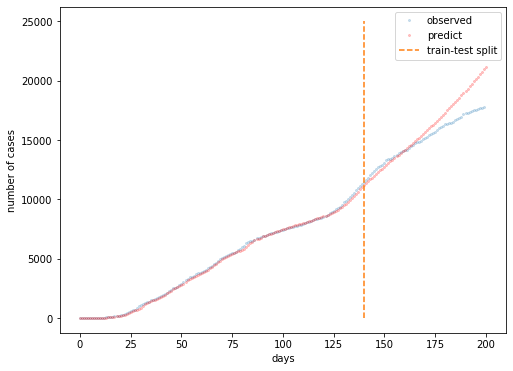

In [15]:
fig,ax = plt.subplots(figsize=(8,6)) 
ax.plot(cases,'o',markersize=2,alpha=0.2,label='observed') 
ax.plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict') 
ax.plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split') 
ax.set_xlabel('days') 
ax.set_ylabel('number of cases') 
ax.legend()

# Testing performance

The code below is used to continue testing on Baltimore County using varying step sizes, which changes how many days are used for predictions.

KeyboardInterrupt: 

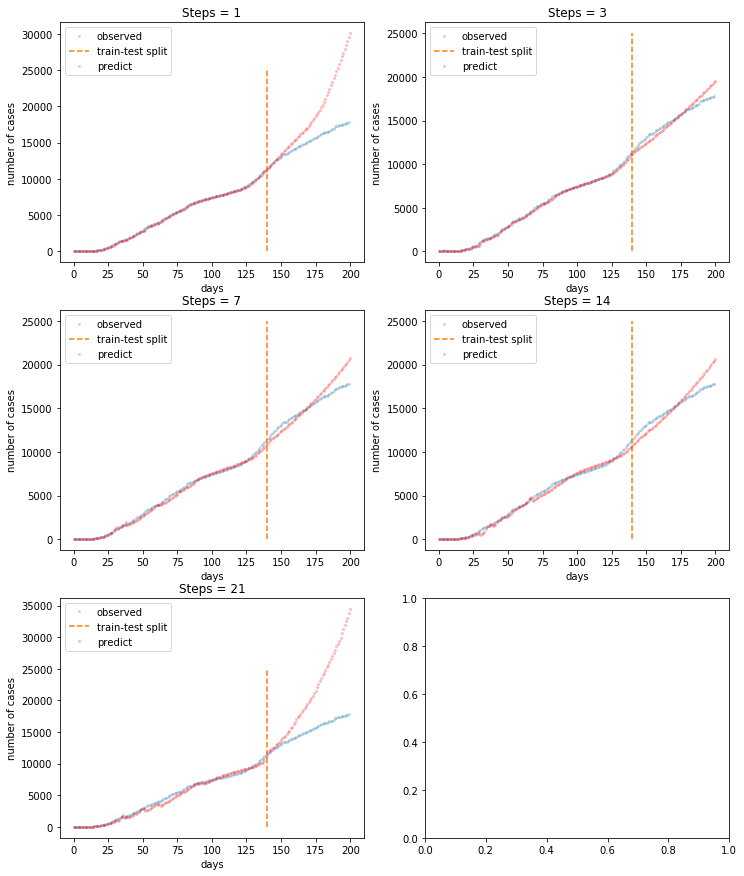

In [16]:
steps_list = [1,3,7,14,21,30] 
 
fig,ax = plt.subplots(3,2,figsize=(12,15)) 
 
# By the way, take a look at these numpy commands: reshape and where 
rowcollist = np.arange(1,7) 
 
# 4,3 means 4 rows, 3 columns 
rowcollist = rowcollist.reshape(3,2) 
 
for i in range(0,len(rowcollist)): 
    row,col = np.where(rowcollist == i+1) 
    #print(row[0], col[0]) 

# Perform prediction: 
for i in range(len(steps_list)): 
    # choose a number of time steps (how many days to use for prediction) 
    n_steps = steps_list[i] 
    test_train_split = 0.7      
    yhat_array = make_prediction(COVID_baltimore_df, stat_data_baltimore, test_train_split, n_steps) 
     
    row, col = np.where(rowcollist == i+1) 
    ax[row[0]][col[0]].plot(cases,'o',markersize=2,alpha=0.2,label='observed') 
    ax[row[0]][col[0]].plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split') 
    ax[row[0]][col[0]].plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict') 
    ax[row[0]][col[0]].set_xlabel('days') 
    ax[row[0]][col[0]].set_ylabel('number of cases') 
    ax[row[0]][col[0]].legend() 
    ax[row[0]][col[0]].set_title('Steps = ' + str(steps_list[i])) 
fig.show

# Find Delta with Varying Steps

The code below is a continuation of the **Testing Performance** section above. Various step sizes are still being tested for COVID cases from Baltimore County, but instead of actual cases, the difference between the actual number of cases and the predicted value are plotted. This will be used to determine what the best step value is for the model.

<bound method Figure.show of <Figure size 864x1080 with 6 Axes>>

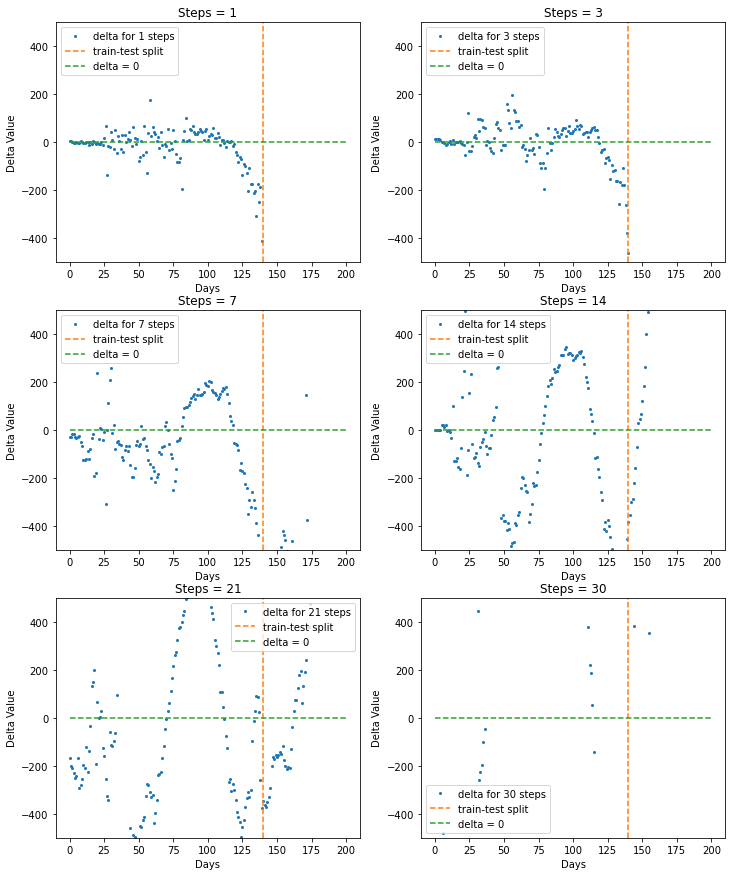

In [13]:
# Perform prediction:
fig,ax = plt.subplots(3,2,figsize=(12,15)) 
for i in range(len(steps_list)):
    # choose a number of time steps (how many days to use for prediction)
    n_steps = steps_list[i]

    yhat_array = make_prediction(COVID_baltimore_df, stat_data_baltimore, test_train_split, n_steps) 
    delta_array = yhat_array - cases[n_steps:]
    row, col = np.where(rowcollist == i+1)
    ax[row[0]][col[0]].plot(delta_array,'o',markersize=2,label='delta for '+str(steps_list[i])+ ' steps')
    ax[row[0]][col[0]].plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[-500,500],'--',label='train-test split')
    ax[row[0]][col[0]].plot([0,200],[0,0],'--',label='delta = 0')
    ax[row[0]][col[0]].set_xlabel('Days')
    ax[row[0]][col[0]].set_ylabel('Delta Value')
    ax[row[0]][col[0]].set_ylim(bottom = -500, top = 500)
    ax[row[0]][col[0]].legend()
    ax[row[0]][col[0]].set_title('Steps = ' + str(steps_list[i]))
fig.show

After running the above test, it was determined that a step size of 1 was best to be used for the predicted model, although none of the step sizes had a reasonably low error. Next the error margin will be tested with different test and training set sizes to see the best value to go with a step size of 1.

# Find Error Margin with Different Test Set Sizes

The following cell block makes a prediction model for different ratios of test to training datasets. Each prediction is shown in the output plots.

<bound method Figure.show of <Figure size 864x1080 with 6 Axes>>

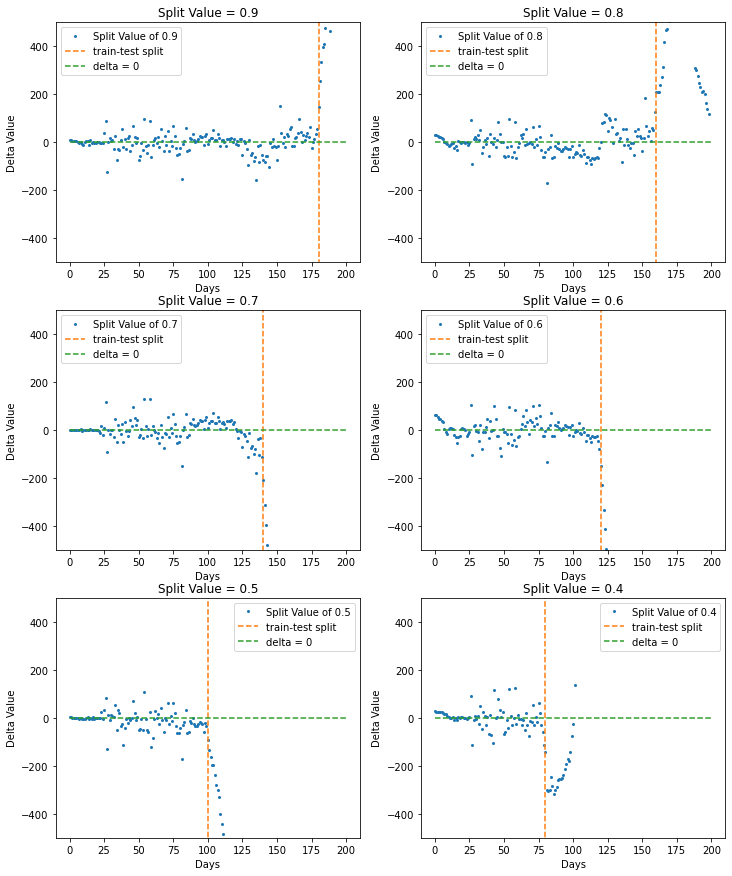

In [14]:
# Split data to train the model: 70:30
split_value = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
fig,ax = plt.subplots(3,2,figsize=(12,15)) 
for i in range(0,len(split_value)):
    n_steps = 1
    test_train_split = split_value[i]
    yhat_array = make_prediction(COVID_baltimore_df, stat_data_baltimore, test_train_split, n_steps)
    delta_array = yhat_array - cases[(len(cases)-len(yhat_array)):]
    
    row, col = np.where(rowcollist == i+1)
    ax[row[0]][col[0]].plot(delta_array,'o',markersize=2,label='Split Value of '+str(split_value[i]))
    ax[row[0]][col[0]].plot([int(len(cases)*split_value[i]),int(len(cases)*split_value[i])],[-20000,50000],'--',label='train-test split')
    ax[row[0]][col[0]].plot([0,200],[0,0],'--',label='delta = 0')
    ax[row[0]][col[0]].set_ylim(bottom = -500, top = 500)
    ax[row[0]][col[0]].set_xlabel('Days')
    ax[row[0]][col[0]].set_ylabel('Delta Value')
    ax[row[0]][col[0]].legend()
    ax[row[0]][col[0]].set_title('Split Value = ' + str(split_value[i]))
fig.show

 It was decided that the split value of **90% to 10%** would be best for the predictions based on the plots below based on its consistency and smaller error over a slightly longer period of time.

# Model the Error Margin Using Optimal step and split values

The following set of code using the step value of 1 and a split value of 0.9, which were found as the optimal settings for the prediction model. These settings are used to model the error of the predictions, using the predicted data subtracted from the actual data.

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

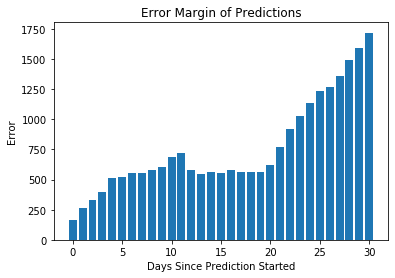

In [29]:
n_steps = 1
split_value = 0.9    
yhat_array = make_prediction(COVID_baltimore_df, stat_data_baltimore, test_train_split, n_steps)
delta_array = yhat_array - cases[(len(cases)-len(yhat_array)):]
fig,ax = plt.subplots()
ax.bar(x = range(0,31),height = abs(delta_array[int(len(cases)*test_train_split):int(len(cases)*test_train_split)+31]))
ax.set_xlabel('Days Since Prediction Started')
ax.set_ylabel('Error')
ax.set_title('Error Margin of Predictions')
fig.show

# Run the Error Margin 30 Times to Find Best Prediction Time

The following code runs the error margin 30 times and finds where the threshold of plus or minus 60 cases is met. The day at which this maximum occurs is then stored, and then the mean time of these 30 days is calculated. This is found to be the maximum time the model can reasonably predict in 30 days.

In [ ]:
forecastDays_array = []
for j in range(0,30):

    n_steps = 1
    split_value = 0.9    
    yhat_array = make_prediction(COVID_baltimore_df, stat_data_baltimore, test_train_split, n_steps)
    delta_array = abs(yhat_array - cases[(len(cases)-len(yhat_array)):])
    delta_array2 = abs(delta_array[int(len(cases)*test_train_split):])
    
    counter = 0
    for i in range(0,len(delta_array2)):
        if delta_array2[i] <300:
            counter = counter + 1
        elif delta_array2[i] >= 300:
            break

    forecastDays_array.append(counter)
    print(forecastDays_array)

[4]
[4, 9]
[4, 9, 0]
[4, 9, 0, 1]
[4, 9, 0, 1, 10]
[4, 9, 0, 1, 10, 0]
[4, 9, 0, 1, 10, 0, 0]
[4, 9, 0, 1, 10, 0, 0, 0]
[4, 9, 0, 1, 10, 0, 0, 0, 0]
[4, 9, 0, 1, 10, 0, 0, 0, 0, 24]
[4, 9, 0, 1, 10, 0, 0, 0, 0, 24, 8]
[4, 9, 0, 1, 10, 0, 0, 0, 0, 24, 8, 4]


Because 27/30 of the values were 26 days, the 

# Run the model with all counties

The following cell blocks are used to predict the number of covid cases for all counties in the US. The *forecast_num* is the number of days the algorithm will predict ahead. This was chosen by the previous set of code based on a mean error margin of plus or minus 60 cases.

In [16]:
# Function to apply model to all available counties

def predict_all(ts_df,stat_df,forecast_num): 
    prediction_df = pd.DataFrame(columns = ['State','County','Predicted cases']) 
    list_counties = list(stat_df[['State', 'County']].apply(tuple,axis=1)) 
    it = iter(range(len(list_counties[0:5]))) #only run model for the first 5 counties
    for i in it: 
        # time-series data of the county 
        county_ts = ts_df.loc[(ts_df['State']==list_counties[i][0])& (ts_df['County']==list_counties[i][1])]  
        # stationary data of the county 
        county_stat_df = stat_df.loc[(stat_df['State']==list_counties[i][0])&(stat_df['County']==list_counties[i][1])] 
        county_stat = county_stat_df.drop(columns=['County', 'State']).values.tolist() 
        county_stat = np.array(county_stat[0]) 
        # Make prediction 
        n_steps = 1 
        test_train_split = 0.7 
        yhat_array = make_prediction(county_ts, county_stat, test_train_split, n_steps) 
        # Dataframe of results 
        county_pred = pd.DataFrame([[list_counties[i][0],list_counties[i][1],
                                     yhat_array[int(len(cases)*test_train_split):int(len(cases)*test_train_split)+forecast_num]]],
                                     columns=['State','County','Predicted cases'])
        prediction_df = prediction_df.append(county_pred) 
    prediction_df = prediction_df.reset_index()
    del prediction_df['index']
    return prediction_df

In [17]:
forecast_num=14
prediction_df = predict_all(COVID_counties_df,df,forecast_num)

In [18]:
display(prediction_df)

,State,County,Predicted cases
0,AL,Autauga,"[1147.7247314453125, 1154.7706298828125, 1161...."
1,AL,Baldwin,"[3407.30322265625, 3517.8720703125, 3629.85327..."
2,AL,Barbour,"[659.1021118164062, 659.9255981445312, 660.675..."
3,AL,Bibb,"[422.8220520019531, 424.2574157714844, 425.569..."
4,AL,Blount,"[1202.9019775390625, 1239.6014404296875, 1276...."
